# [Lesson 2 : LangGraph Components](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/3/langgraph-components)

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [6]:
class Agent:
    
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", 'llm')
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
    
    def exists_action(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0
    
    def call_openai(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}
    
    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
            print("Back to the model!")
        return {'messages': results}



In [11]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-4o-mini")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

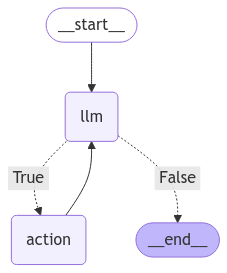

In [12]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_mermaid_png())

In [13]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_MtevRumBaf3I1V1p0XBoXQgT', 'type': 'tool_call'}
Back to the model!


In [14]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MtevRumBaf3I1V1p0XBoXQgT', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 151, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1b237791-2ccb-45c1-9172-3883166d3ea0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_MtevRumBaf3I1V1p0XBoXQgT', 'type':

In [15]:
result['messages'][-1].content

'The current weather in San Francisco is as follows:\n\n- **Temperature**: 9.3°C (48.7°F)\n- **Condition**: Sunny\n- **Wind**: 16.3 mph (26.3 kph) from the northeast\n- **Humidity**: 66%\n- **Visibility**: 16 km (9 miles)\n- **Pressure**: 1025 mb (30.28 in)\n- **Feels Like**: 5.9°C (42.7°F)\n\nFor more detailed updates, you can check out [WeatherAPI](https://www.weatherapi.com/) or local news sources like [KRON4](https://www.kron4.com/weather/san-francisco-bay-area-weather-forecast/).'

In [16]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather San Francisco'}, 'id': 'call_WjNRM8ra8XYmPQ7fFcvFXbSk', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather Los Angeles'}, 'id': 'call_CPTePKEdg3SfbWjVxibWQog0', 'type': 'tool_call'}
Back to the model!


In [17]:
result['messages'][-1].content

"Here's the current weather for San Francisco and Los Angeles:\n\n### San Francisco\n- **Temperature**: 9.3°C (48.7°F)\n- **Condition**: Sunny\n- **Wind**: 16.3 mph (26.3 kph) from the Northeast\n- **Humidity**: 66%\n- **Visibility**: 16.0 km (9.0 miles)\n- **Feels Like**: 5.9°C (42.7°F)\n\n### Los Angeles\n- **Temperature**: 7.8°C (46.0°F)\n- **Condition**: Sunny\n- **Wind**: 4.7 mph (7.6 kph) from the North-Northeast\n- **Humidity**: 38%\n- **Visibility**: 16.0 km (9.0 miles)\n- **Feels Like**: 6.5°C (43.8°F)\n\nBoth cities are experiencing sunny weather with mild temperatures."

In [20]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_igQoxv4ZKz5Dg54dhCHloFXD', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_SdAS44WmgmaCi4BaWCqdmpkt', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2024'}, 'id': 'call_qhxhiRTWmHDVt9mH3Ibd7tR1', 'type': 'tool_call'}
Back to the model!


In [21]:
print(result['messages'][-1].content)

1. The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers 25-22.

2. The headquarters of the Kansas City Chiefs is located in Missouri, specifically at One Arrowhead Drive, Kansas City, MO.

3. The GDP of Missouri in 2023 was approximately $430 billion. Specific data for 2024 wasn't available, but it can be inferred to be close to this figure with expected growth.


In [22]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o-mini")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_S9EcMNhkP84G4AVVW1QS0sE8', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_pXbV56zvAx5AXUhF27ukqObt', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri 2024'}, 'id': 'call_CK2loJmtC2fJEr3OJuypokWz', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2023'}, 'id': 'call_hJXRI1BBJonAZmmexO1hxY2h', 'type': 'tool_call'}
Back to the model!


In [23]:
print(result['messages'][-1].content)

1. **Super Bowl 2024 Winner**: The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers with a score of 25-22 in overtime.

2. **State of Winning Team Headquarters**: The Kansas City Chiefs are headquartered in Missouri.

3. **GDP of Missouri**: In 2023, the real gross domestic product (GDP) of Missouri was approximately $344.12 billion.
